### Match Score model 

#### A new fairness metric and a new approach to simulate the following season by adjusting relative financial values of clubs

During the project period of Mathematical Modelling in Football course given by David Sumpter (Please feel free to see the course content: https://uppsala.instructure.com/courses/28112/assignments/syllabus), one part of the task given us was assessing the club's (Inter Milan in our case) performance for 17/18 season and simulating 18/19 under different scenarios. My team leader Lodve Berre (https://www.linkedin.com/in/lodve-berre/) came up with the idea that xG (Expected goals, for brief definition: https://en.wikipedia.org/wiki/Expected_goals) is not enough to assess the fairness of the season, since some teams really dominate the pitch very well throughout games but could not create "enough" xG to prove that they were indeed good, since xG is purely shot-based. Thanks to his initial thought, I created a new fairness metric, so-called xG&T, which weights xG and Karun Singh's xT (https://karun.in/blog/expected-threat.html, a metric that is not only shot-based, but also rewards attacking actions regardless of the end outcome of the possession.) with respect to shot ratio and possession. The formula can be seen in the below:

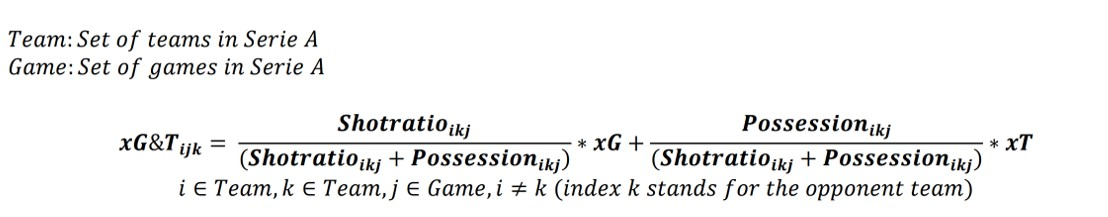

The xG&T value skews towards xG when the team manages to convert their attempts into shots while it skews towards xT value while the team dominates the game rather by possession instead of shots. Poisson regression model showed us that xG&T value has a significant impact on goals, when controlled by the team and opponent. Along with this new metric, we simulated 17/18 Serie A season and concluded that teams rankings by the end of the season was "fair enough". The poisson model that assesses the fairness of 17/18 season for Serie A is:

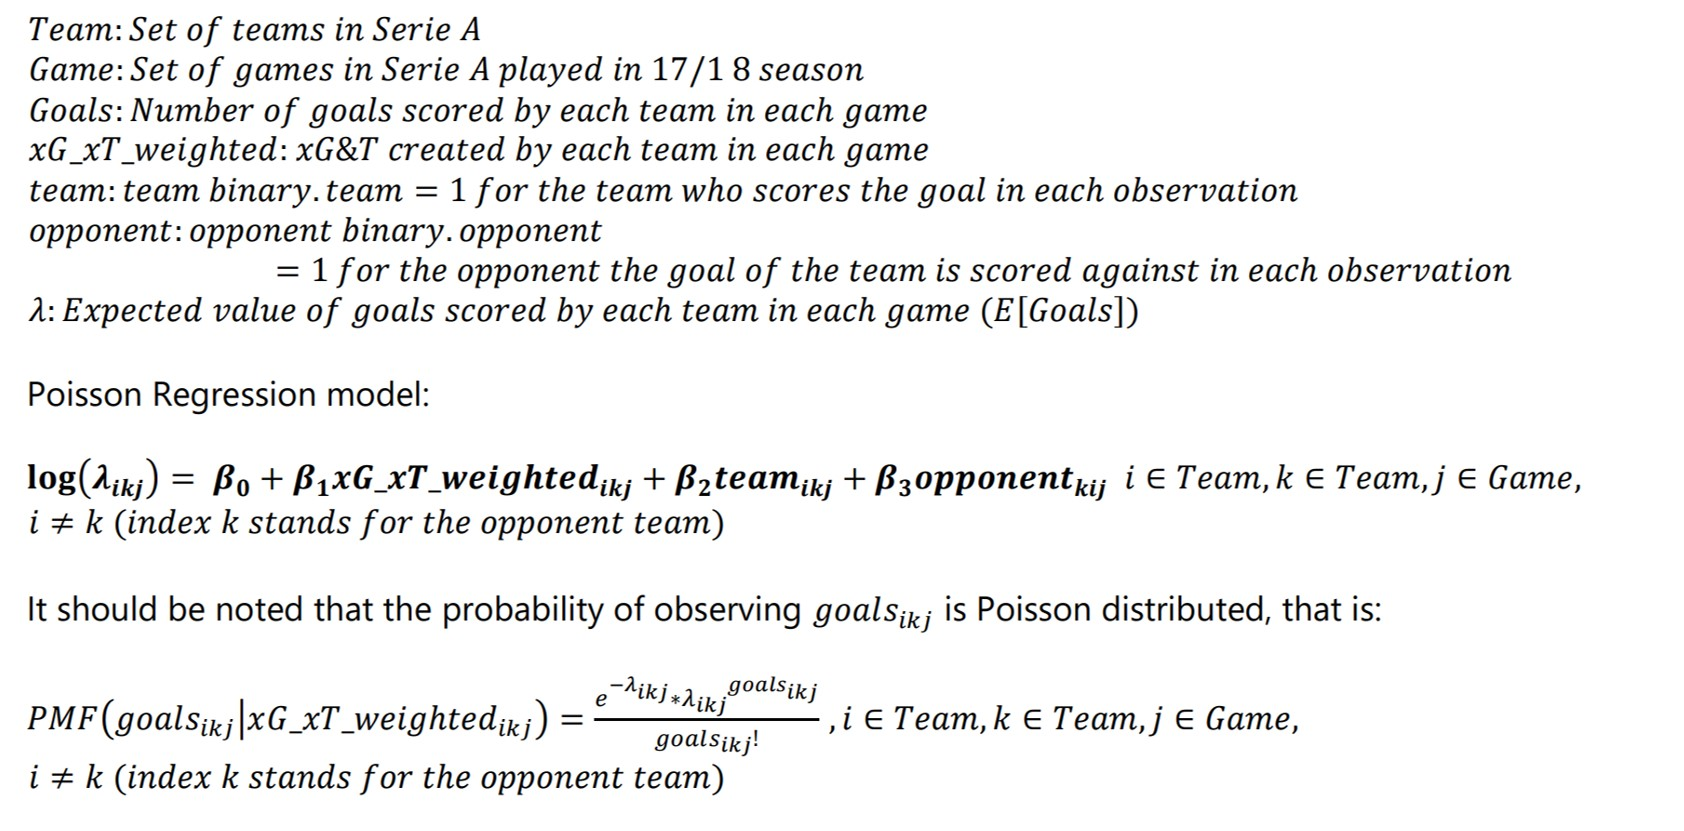

This is not a model that was built from scratch, as it is in fact an adjusted version of Maher (1982, www.90minut.pl/misc/maher.pdf) and Dixon-Coles (More information and the code that I partly adapted to my case can be found here: https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/ and here:https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/) models. The difference is that our model's key input is xG&T. 

For the upcoming season (18/19), we came up with a number of financial scenarios (such as if Inter does not invest in its squad as much as its rivals, or vice versa). To change the input for each simulation, I used transfermarkt's club values (May 2018, end of season) as base. Our initial findings pointed out that FiveThirthyEight's (https://projects.fivethirtyeight.com/soccer-predictions/serie-a/) offensive and defensive attributes assigned for each team is a very good predictor (The offensive attribute of the team and the defensive attribute of the opponent is significantly and positively correlated with the goal scored by the team in any given game.). Thus, in order to adjust these values with respect to different financial scenarios, I derived the below formula (Weighted offensive and defensive attributes), which connects these attributes with the club's overall point so-called SPI, assigned by FiveThirtyEight's own calculation. 

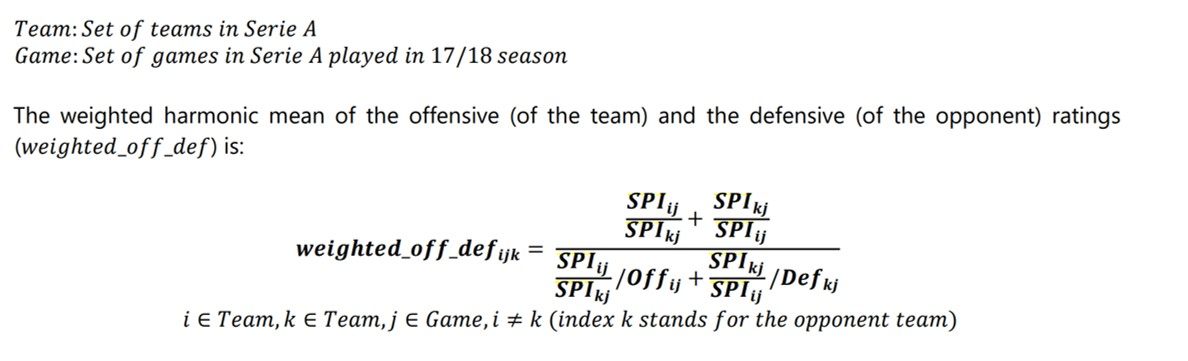

In this way, we will be able to recalculate SPI ratings of each team and opponent to reflect the abovementioned scenarios we want to simulate, and the weighted harmonic mean will change accordingly. Our assumption here is that the
changes in for instance squad value (without any knowledge of a specific players added to the squad) will have an impact on the club’s offensive and defensive ratings. We realize this impact by increasing the SPI values instead of the metrics themselves, and then use the weighted harmonic average that we presented above for each observation. Moreover, we added the home advantage into our model, as unlike in xG&T (which is different for every game as they reflect actual events), offensive and defensive ratings do not contain home advantage information (values do not change per game, there is one single offensive and one single defensive rating for each team, and therefore opponent.). Therefore, our final simulation model for 18/19 season is realized by a Poisson Regression model as follows:

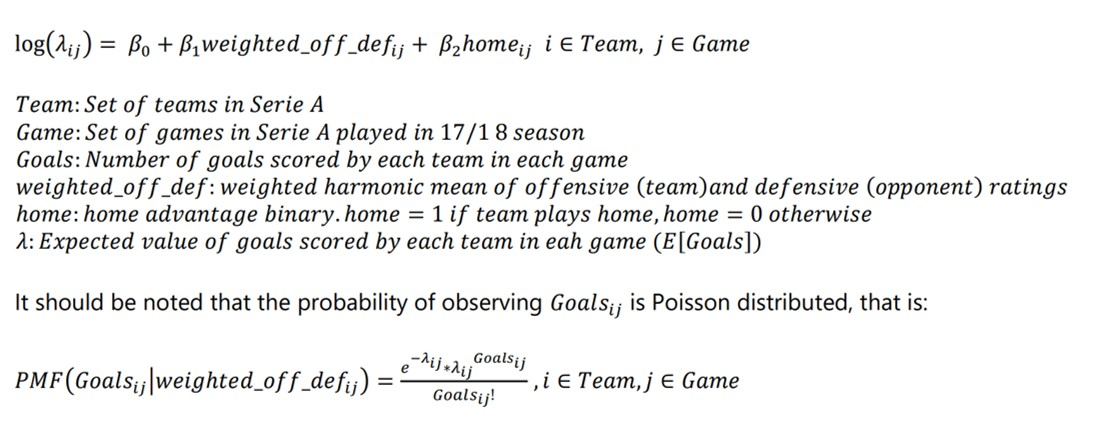


For each scenario, weighted_off_def value changes with respect to the changes in club's values. Club_Value_Excel.xlsx file is designed to automatically recalculate the SPIs for each team under different financial scenarios. The only thing to be entered is a theoretical club value growth rate for each team (Which can be adjusted to any possible financial scenarios.). The recalculation process relies on one assumption, that is:

If the difference in a club’s value relative to mean from May 2018 to September 2018 changes by 0.1, the SPI rating of the corresponding club changes by 0.5. How I calculated the differences in clubs’ values relative to mean from May 2018 (end of 17/18) to September 2018 (start of 18/19) can be seen in the below:

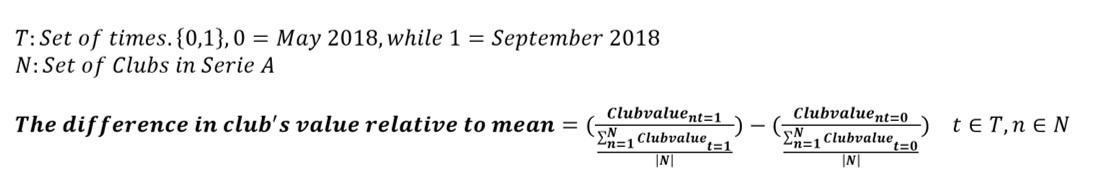

The below code is to show how I converted the dataset of Wyscout data (Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000, Retrieved from: https://figshare.com/collections/Soccer_match_event_dataset/4415000/2) into a "modelling-friendly" form. It contains the code for modelling as well. Events, xG and xT values are exogenously provided by my team leader. Except Wyscout data (which can be downloaded from the above link), all datasets that are used while modelling can be found under the relevant folder. 

Essentials first

In [ ]:
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
with open('YOUR/PATH/TO/FOLDER/matches_Italy.json') as f:
    data = json.load(f)

Raw data itself is far from being enough to run the model right away. As one can foresee, since here we try to build a model that will eventually predict the number of goals for each team in each game, technically there are two observations within each game. One for the team, one for the opponent, as we try to predict number of goals for two teams. Therefore, since every game will be represented by two rows in our dataset, those should be distinguished with a binary called "home", which is 1 when the goal to be predicted will be for the home team, and 0 otherwise. Below codes show how it is converted in a "modelling-friendly" form.  

In [ ]:
df = pd.DataFrame(data)
df = df['label']
df = pd.DataFrame(df)
df['HomeTeam'], df['B'] = df['label'].str.split(' ', 1).str
df['HomeTeam']= df['HomeTeam'].replace('Hellas', "Hellas Verona") 

##Fixing it for Hellas Verona since it is seperated as well due to having ' '. 
df2 = df[df.B.str.startswith('Verona')]
df2['C'], df2['D'] = df2['B'].str.split(' ', 1).str
df2 = df2[['label', 'HomeTeam', 'D']]
df2.rename(columns={'D':'B'}, inplace=True)
df2 = df2.reset_index()


df = df[~df.B.str.startswith('Verona')]
df = df.reset_index()


df3 = pd.concat([df, df2])
df3 = df3.sort_values('index')
df3 = df3.set_index('index')
df3['B'] = df3['B'].str[2:]

df3[['AwayTeam', 'score']] = df3.B.apply(lambda x: pd.Series(str(x).split(",")))
df4 = df3[['HomeTeam', 'AwayTeam', 'score']]
df5 = df4.score.apply(lambda x: pd.Series(str(x).split(" ")))
dict5 = {0:'0', 1:'FTHG', 2:'2', 3:'FTAG'}
df5.columns = df5.columns.to_series().map(dict5)
df5 = df5[['FTHG', 'FTAG']]

df6 = pd.concat([df4, df5], axis=1, join='inner')
dfmaster = df6[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]

In this case, I did not run any models on current SPI, offensive and defensive metrics of Serie A teams, since we were tasked to assess the performance of the team for 17/18 season and make predictions about the following one. But, here I am merging it to the main dataset just in case, perhaps one would like to run a model on to see how powerful FiveThirtyEight data is in terms of match score prediction. 

In [ ]:
## - Merging SPIs to the master dataframe - ##
df_spi = pd.read_csv("spi_serie_a_2020-2021.csv") 
df_spi['Team'] = df_spi['Team'].replace('Verona', "Hellas Verona")
df_spi['Team'] = df_spi['Team'].replace('Inter Milan', "Internazionale")
df_spi['Team'] = df_spi['Team'].replace('AC Milan', "Milan")
teams = pd.DataFrame(dfmaster['HomeTeam'].unique())
dictteams = {0:'Team'}
teams.columns = teams.columns.to_series().map(dictteams)
teams['dummy'] = 0
test = df_spi.merge(teams, how="outer")
# Parma and Spezia not in dfmaster, while Chievo and SPAL do not have SPIs.
# Parma and Spezia will be deleted as we will run the model on 17/18 season.

dfmaster_spi = test.drop([test.index[14], test.index[19]]) 
dfmaster_spi = dfmaster_spi[['Team', 'SPI', 'Off', 'Def']]
dfmaster_spi.rename(columns={'Team':'HomeTeam'}, inplace=True)

del [[df, df2, df3, df4, df5, df6]]
del [[df_spi, teams, test]]

dfmaster = pd.merge(dfmaster, dfmaster_spi, on=['HomeTeam'])

With the below code, the dataset is ready for modelling. 

In [ ]:
model_df = pd.concat([dfmaster[['HomeTeam','AwayTeam','FTHG', 'SPI', 'Off', 'Def']].assign(home=1).rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','FTHG':'goals'}), dfmaster[['AwayTeam','HomeTeam','FTAG', 'SPI', 'Off', 'Def']].assign(home=0).rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','FTAG':'goals'})])
model_df['goals'] = model_df['goals'].astype(int) 
model_df['home'] = model_df['home'].astype(int) 

To exemplify, Maher's (1982) approach can be tested on Serie A with the below code. 

In [ ]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=model_df, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

Now it is time to start dealing with the real task. Thus, xG and xT values and end-of-season (17/18) FiveThirtyEight data are merged to the main dataset. Below codes shows the entire data manipulation process. As mentioned, ready-made excel files are under the relevant github folder. 

In [ ]:
## Start with deleting the FiveThirthyEight 2020 data that we initially put only as an example. 

model_df = pd.concat([dfmaster[['HomeTeam','AwayTeam','FTHG']].assign(home=1).rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','FTHG':'goals'}), dfmaster[['AwayTeam','HomeTeam','FTAG']].assign(home=0).rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','FTAG':'goals'})])
model_df['goals'] = model_df['goals'].astype(int) 
model_df['home'] = model_df['home'].astype(int) 

## Now merging the relevant FiveThirthyEight data. 
df_1718spi = pd.read_excel("spi_serie_ab_2017-2018_EOS.xlsx")
df_1718spi.rename(columns={'Team':'team'}, inplace=True)
df_1718spi_off = df_1718spi[['team', 'SPI', 'Off']]
df_1718spi_def = df_1718spi[['team', 'Def']]
df_1718spi_def.rename(columns={'team':'opponent'}, inplace=True)

## To detect what teams to rename - unifying team names is a must in order not to cause an unwanted outcome while merging. 
teamname_unified = pd.DataFrame()
test = pd.DataFrame()
teamname_unified['model'] = model_df.team.unique()
teamname_unified['dummy'] =0
test['model'] = df_1718spi_off.team.unique()
#Teams to be renamed detected - Verona and Inter. 
test = test.merge(teamname_unified, how="outer")

## Teams to be renamed
df_1718spi_off['team']= df_1718spi_off['team'].replace('Verona', "Hellas Verona") 
df_1718spi_off['team']= df_1718spi_off['team'].replace('Inter', "Internazionale") 


df_1718spi_def['opponent']= df_1718spi_def['opponent'].replace('Verona', "Hellas Verona") 
df_1718spi_def['opponent']= df_1718spi_def['opponent'].replace('Inter', "Internazionale") 


## team's SPI and attacking attribute
model_df = pd.merge(model_df, df_1718spi_off, on=['team'], how='outer')
model_df.drop(model_df.loc[760:].index, inplace=True)

## opponent's defensive attribute, for each goal, what matters is team's attacking and the opponent's defensive attributes. Since these are correlated on the same direction with team's goal (Positive).
## team's defensive attribute has no or marginal effect on the goal number of each team in each game, so that's why the dataset should be formed like that.
model_df = pd.merge(model_df, df_1718spi_def, on=['opponent'], how='outer')
model_df.drop(model_df.loc[760:].index, inplace=True)

##Other game attributes (Possession, shots and other candidate features) are merged by the code in the below.
df_seriea = pd.read_excel("Game_report_2017-18.xlsx")
df_seriea['Home'] = df_seriea['Home'].replace('Chievoverona', "Chievo") 
df_seriea['Home'] = df_seriea['Home'].replace('Spal', "SPAL")  
df_seriea['Away'] = df_seriea['Away'].replace('Chievoverona', "Chievo") 
df_seriea['Away'] = df_seriea['Away'].replace('Spal', "SPAL")

model_df_home = model_df.loc[(model_df['home'] == 1)]
model_df_away = model_df.loc[(model_df['home'] == 0)]

df_seriea_home = df_seriea
df_seriea_home.rename(columns={'Home':'team'}, inplace=True)
df_seriea_home.rename(columns={'Away':'opponent'}, inplace=True)

df_seriea_home = df_seriea_home[['team', 'opponent', 'home Possession', 'home Total Shots', 'away Total Shots', 'away Fouls Made', 'home Sending-Offs', 'away Sending-Offs']]

model_df_home = pd.merge(model_df_home, df_seriea_home, on=['team', 'opponent'], how='outer')

df_seriea_away = df_seriea
df_seriea_away.rename(columns={'Away':'team'}, inplace=True)
df_seriea_away.rename(columns={'Home':'opponent'}, inplace=True)

df_seriea_away = df_seriea_away[['team', 'opponent', 'away Possession', 'away Total Shots','home Total Shots', 'home Fouls Made', 'home Sending-Offs', 'away Sending-Offs']]

model_df_away = pd.merge(model_df_away, df_seriea_away, on=['team', 'opponent'], how='outer')

dicthome = {'team':'team', 'opponent':'opponent', 'goals':'goals', 'home':'home', 'SPI':'SPI', 'Off':'Off', 'Def':'Def', 'home Possession':'Possession_rate', 'home Total Shots':'Total_shots_team', 'away Total Shots':'Total_shots_opponent', 'away Fouls Made':'Fouls_made_against', 'home Sending-Offs':'team_sending_off', 'away Sending-Offs':'opponent_sending_off'}
dictaway = {'team':'team', 'opponent':'opponent', 'goals':'goals', 'home':'home', 'SPI':'SPI', 'Off':'Off', 'Def':'Def', 'away Possession':'Possession_rate', 'away Total Shots':'Total_shots_team', 'home Total Shots':'Total_shots_opponent', 'home Fouls Made':'Fouls_made_against', 'home Sending-Offs':'opponent_sending_off', 'away Sending-Offs':'team_sending_off'}

model_df_home.columns = model_df_home.columns.to_series().map(dicthome)
model_df_away.columns = model_df_away.columns.to_series().map(dictaway)

model_df_home['Total_shots'] = model_df_home['Total_shots_team'] + model_df_home['Total_shots_opponent']
model_df_away['Total_shots'] = model_df_away['Total_shots_team'] + model_df_away['Total_shots_opponent']

##Finally xG and xT values are gathered. 
xGxT = pd.read_hdf('simulation.h5')

teamname_unified2 = pd.DataFrame()
test2 = pd.DataFrame()
teamname_unified2['model'] = model_df_home.team.unique()
teamname_unified2['dummy'] =0
test2['model'] = xGxT.Team.unique()
test3 = test2.merge(teamname_unified2, how="outer")
## Hellas to be renamed Hellas Verona

xGxT['Team']= xGxT['Team'].replace('Hellas', "Hellas Verona") 
xGxT['Against']= xGxT['Against'].replace('Hellas', "Hellas Verona") 

xGxT = xGxT[['Team', 'Against', 'xG', 'xT', 'home']]

dict123 = {'Team':'team', 'Against':'opponent', 'home':'home', 'xG':'xG', 'xT':'xT'}
xGxT.columns = xGxT.columns.to_series().map(dict123)

xGxT_home = xGxT.loc[(xGxT['home'] == 1)]
xGxT_away = xGxT.loc[(xGxT['home'] == 0)]

model_df_home_test = pd.merge(model_df_home, xGxT_home, on=['team', 'opponent', 'home'], how='outer')
model_df_away_test = pd.merge(model_df_away, xGxT_away, on=['team', 'opponent', 'home'], how='outer')

##xG and xT values are merged. 
model_df_final = pd.concat([model_df_home_test, model_df_away_test])

model_df_final.to_excel("Poission_model_data.xlsx", sheet_name='Poisson_model_data')  
## The weighted value of xG and xT is calculated in Excel. But the formula itself is provided above so one can use Python too.
model_df = pd.read_excel("Poisson_model_data.xlsx")


Further additions are made with the below code. Such as the opponent's SPI as well, since it will be used while calculating weighted offensive and defensive attributes, which is calculated for simulating the following season. 

In [ ]:
## Now it is time to add finally the SPI of the opponent team. This is going to be used for calculating weighted_off_def.
df_1718spi_ = df_1718spi[['team', 'SPI']]
df_1718spi_['team']= df_1718spi_['team'].replace('Verona', "Hellas Verona") 
df_1718spi_['team']= df_1718spi_['team'].replace('Inter', "Internazionale")
df_1718spi_.rename(columns={'team':'opponent'}, inplace=True)

model_df = pd.merge(model_df, df_1718spi_, on=['opponent'], how='outer')
model_df.drop(model_df.loc[760:].index, inplace=True)

model_df = model_df[['team', 'opponent', 'goals', 'home', 'SPI_18', 'Off_18', 'Def_18', 'Possession_rate', 'Total_shots_team', 'Total_shots_opponent', 'Total_shots', 'xG', 'xT', 'Team_shots_ratio', 'xG_xT_weighted', 'SPI']]
model_df.rename(columns={'SPI':'SPI_18_opponent', 'SPI_18': 'SPI_18_team'}, inplace=True)

Some candidate metrics can be found in the below. But we will model with xG_xT_weighted and weighted_off_def. These are added in case one would like to test some other model candidates. 

In [ ]:
model_df['weighted_off_def'] = ((model_df['SPI_18_team']/model_df['SPI_18_opponent'])+(model_df['SPI_18_opponent']/model_df['SPI_18_team']))/(((model_df['SPI_18_team']/model_df['SPI_18_opponent'])/model_df['Off_18'])+((model_df['SPI_18_opponent']/model_df['SPI_18_team'])/model_df['Def_18']))
model_df['weighted_SPI'] = ((model_df['Off_18']/model_df['Def_18'])+(model_df['Def_18']/model_df['Off_18']))/(((model_df['Off_18']/model_df['Def_18'])/model_df['SPI_18_team'])+((model_df['Def_18']/model_df['Off_18'])/model_df['SPI_18_opponent']))
model_df['log_goals'] = np.log(model_df['goals'])
model_df['log_weighted_off_def'] = np.log(model_df['weighted_off_def'])

model_df['harmonic_xG_xT_weighted'] = (model_df['Team_shots_ratio']/(model_df['Team_shots_ratio']+model_df['Possession_rate'])) + (model_df['Possession_rate']/(model_df['Team_shots_ratio']+model_df['Possession_rate'])) / (((model_df['Team_shots_ratio']/(model_df['Team_shots_ratio']+model_df['Possession_rate']))/model_df['xG']) + ((model_df['Possession_rate']/(model_df['Team_shots_ratio']+model_df['Possession_rate']))/model_df['xT']))

model_df['equal_weight'] = (model_df['xG'] + model_df['xT'])/2

Below code is to see our finalized models for assessing 17/18 and simulating 18/19 for different scenarios. One can change the name of variables and try other variable candidates being created above codes. But it should be noted that technically, poisson distribution comes in handy while predicting the number of goals in each game, since it should be used while finding out the probability of a "rare instance" that happens in a certain period of time. If this was a case for another kind of sports, such as basketball, normal distribution would make much more sense since points per game is obviously not as rare as goals in football. The output of the model for assessing 17/18 season with xG&T fairness metric is:

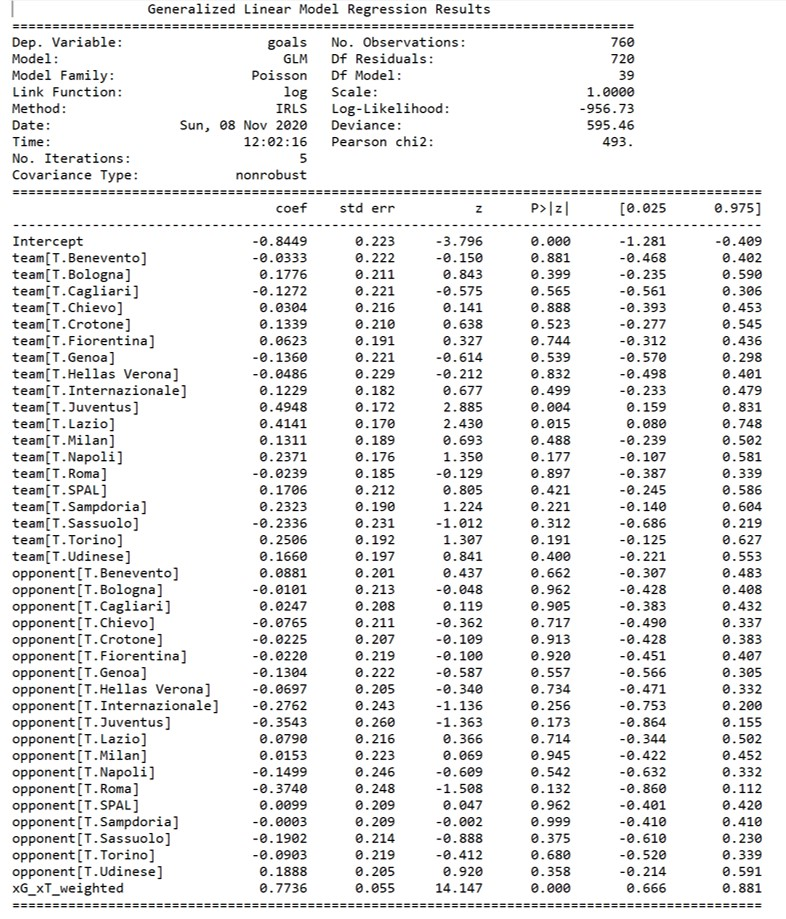

And the output of the model that is built for simulating the following season under different financial scenarios is:

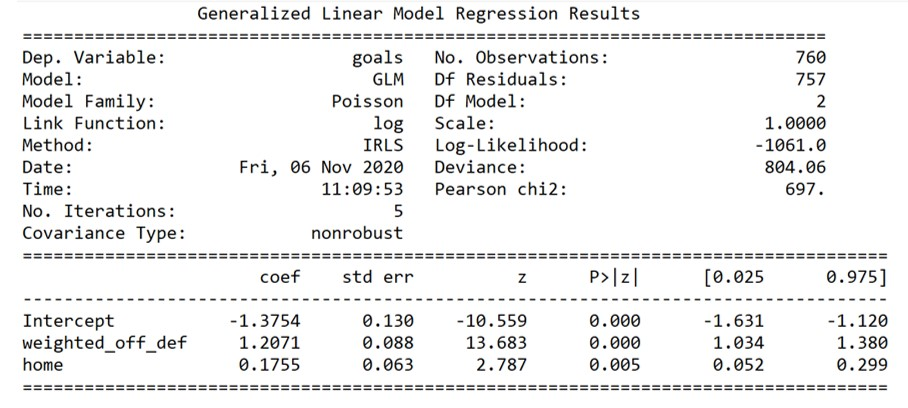


In [ ]:
poisson_model_weighted = smf.glm(formula="goals ~ xG_xT_weighted + team + opponent", data=model_df, 
                        family=sm.families.Poisson()).fit()
poisson_model_weighted.summary()

poisson_model_weighted_off_def = smf.glm(formula="goals ~ weighted_off_def + home", data=model_df, 
                        family=sm.families.Poisson()).fit()
poisson_model_weighted_off_def.summary()

Finally, it is completely optional but one can get the model output as text, with the help of the below code:

In [ ]:
with open('summary_weighted_off_def.txt', 'w') as fh:
    fh.write(poisson_model_weighted_off_def.summary().as_text())